In [1]:
import pandas as pd
import numpy as np
# import locale
import glob
import sys
import os
import requests
import tarfile

import pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
"""inspired by:
https://gist.github.com/zacstewart/5978000
https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb

data description:
http://ai.stanford.edu/~amaas/data/sentiment/
"""

'inspired by:\nhttps://gist.github.com/zacstewart/5978000\nhttps://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/doc2vec-IMDB.ipynb\n\ndata description:\nhttp://ai.stanford.edu/~amaas/data/sentiment/\n'

In [3]:
"Load and pre-format reviews"
# locale.setlocale(locale.LC_ALL, 'C')


# Convert text to lower-case and strip punctuation/symbols from words
def normalize_text(text):
    norm_text = text.lower()

    # Replace breaks with spaces
    norm_text = norm_text.replace('<br />', ' ')

    # Pad punctuation with spaces on both sides
    for char in ['.', '"', ',', '(', ')', '!', '?', ';', ':']:
        norm_text = norm_text.replace(char, ' ' + char + ' ')

    return norm_text


def collect_reviews(datadirname = "../data/"):
    filename = os.path.join(datadirname, 'aclImdb_v1.tar.gz')
    dirname = filename.replace("_v1.tar.gz", "")
    if not os.path.isdir(dirname):
        if not os.path.isfile(filename):
            print("file 'alldata-id.txt' not found; downloading")
            # Download IMDB archive
            url = 'http://ai.stanford.edu/~amaas/data/sentiment/' + filename
            r = requests.get(url)
            with open(filename, 'wb') as f:
                f.write(r.content)
        print("directory '%s' not found; extracting" % dirname)
        tar = tarfile.open(filename, mode='r')
        tar.extractall(path=datadirname)
        tar.close()

    # Concat and normalize test/train data
    folders = ['train/pos', 'train/neg', 'test/pos', 'test/neg', 'train/unsup']
    #     alldata = u''
    alldata = []

    for fol in folders:
        print(fol, file = sys.stderr)
        temp = u''
        output = fol.replace('/', '-') + '.txt'

        # Is there a better pattern to use?
        txt_files = glob.glob('/'.join([dirname, fol, '*.txt']))

        for txtfi in txt_files:
            with open(txtfi, 'r', encoding='utf-8') as t:
                control_chars = [chr(0x85)]
                t_clean = t.read()

                for c in control_chars:
                    t_clean = t_clean.replace(c, ' ')

            id_, stars_ = os.path.basename(txtfi).replace(".txt", "").split("_")
#             print(id_)
            
            dset, judgement = fol.split("/")
            alldata.append( 
                (dset, judgement, id_, stars_, normalize_text(t_clean) )
                )
            
    return alldata

In [4]:
all_reviews_file = "../data/all_reviews.tab"

if not os.path.isfile(all_reviews_file):
    "if no summary file found, collect reviews from separate files:"
    alldata = collect_reviews(datadirname = "../data/")
    alldatadf = pd.DataFrame(alldata,
                 columns = ("dataset", "judgement", "internal_id", "stars", "review" )
                )
    alldatadf.index.name = "id"
    alldatadf.to_csv(all_reviews_file, sep="\t")
else:
    "read summary file"
    alldatadf = pd.read_table(all_reviews_file, index_col=[0])

In [5]:
# !rm ../data/all_reviews.tab

_OK, now we are ready to play with our table!_

In [6]:
alldatadf[:5]

,dataset,judgement,internal_id,stars,review
id,,,,,
0,train,pos,0,9,bromwell high is a cartoon comedy . it ran at...
1,train,pos,10000,8,homelessness ( or houselessness as george car...
2,train,pos,10001,10,brilliant over-acting by lesley ann warren . ...
3,train,pos,10002,7,this is easily the most underrated film inn th...
4,train,pos,10003,8,this is not the typical mel brooks film . it ...


# Explore pandas data classes:
    pd.DataFrame
    pd.DataSeries

**`DataFrame`** object `df` has 2 dimensions:

+    rows indexed by `df.index`
+   columns indexed by `df.columns`

both belong to on of special classes `Index`, `Int64Index`, or `MultiIndex`

index classes have properties `name` and `names` (which is useful for `MultiIndex`)

sometimes it is useful to obtain index values as a list (`.tolist()`) or matrix (`.get_values()`)

In [7]:
alldatadf.columns

Index(['dataset', 'judgement', 'internal_id', 'stars', 'review'], dtype='object')

In [8]:
alldatadf.index.names

FrozenList(['id'])

Each column (or row) of `pd.DataFrame` can be extracted as an object of `pd.Series` class

Usually you will need to extract a column, unless your whole DataFrame columns are of the same type

In [9]:
"two equivalent subsetting operations: DataFrame -> Series"
review = alldatadf["review"]
review = alldatadf.loc[:,"review"]

"""a shorter Series: 
"""
review = alldatadf.loc[alldatadf["stars"]==10, "review"][:3]
3review

id
2     brilliant over-acting by lesley ann warren .  ...
31    when i saw this movie i was stunned by what a ...
32    why do people bitch about this movie and not a...
Name: review, dtype: object

## Changing index

You can pop-up index to a new column by calling

    df.reset_index()
    
Or other way around, move regular columns to the index:

    df.set_index("col_name")
    
    df.set_index(["col_name"])
    
    df.set_index(["col1", "col2", "col3"])  # creates hierarchical MultiIndex

In [23]:
"create multi-index reflecting initial folder structure"
alldatadf.set_index(["dataset","judgement","internal_id"]).sort_index()[:3]

stars  \
dataset judgement internal_id          
test    neg       0                2   
                  1                3   
                  2                3   

                                                                          review  \
dataset judgement internal_id                                                      
test    neg       0            once again mr .  costner has dragged out a mov...   
                  1            this is a pale imitation of 'officer and a gen...   
                  2            it seems ever since 1982 ,  about every two or...   

                               review_len  review_log_len  
dataset judgement internal_id                              
test    neg       0                   934        2.970347  
                  1                   755        2.877947  
                  2                  1493        3.174060

## Subsetting columns

call

    df["col"]
    df.loc[:, "col"]
    
    df[["col","col2","col3"]]
    
    df.iloc[:, :3]  # first three columns

## Subsetting rows

might be confusing for DataFrame

There are N ways to do it.

First, using `df[]` is very ambigous.
When used **with ranges**, such as `df[:4]`, `df[-5:]` it will subset first 4 or last 5 rows respectively. _Otherwise (with integers or strings) it will look for a column, not row!_, i.e. `df[4]` will look for column named `4`.

If you need to get a row **by name**: use

    df.loc["rowname"]

If you need to get a bunch of rows **by boolean mask**: use 
    
    df.loc[mask]

If you need to get a row **by ordinal number**: use 

    df.iloc[42]

In [16]:
alldatadf.set_index(["dataset","judgement","internal_id"]).loc[("train", "pos", 0)]

stars                                                             9
review            bromwell high is a cartoon comedy .  it ran at...
review_len                                                      886
review_log_len                                              2.94743
Name: (train, pos, 0), dtype: object

## Explore pandas functionality:

### `pd.Series` only
    .map
    .sort_values()
    .value_counts() # for categorical data
    
### `pd.DataFrame` only

    .T    #  transpose
    .apply()     # one operation to whole row(axis=1)  or column(axis=0)
    .applymap()  # an operation to each cell
    .groupby().agg()   # ... key(s)
    .corr() # useful for all-numeric data frames

## Generic

these methods accept `axis=` argument for DataFrame
    
    .all()
    .any()
    
    .hist()
    .median()
    .mean()  # <- do not run them on the full alldatadf data frame, as it contains text
    .var()
    .sum()

In [44]:
alldatadf["stars"].value_counts()

0     50000
1     10122
10     9731
8      5859
4      5331
3      4961
7      4803
9      4607
2      4586
Name: stars, dtype: int64

In [30]:
alldatadf[:3].applymap(type)

,dataset,judgement,internal_id,stars,review,review_len,review_log_len
id,,,,,,,
0,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'float'>
1,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'float'>
2,<class 'str'>,<class 'str'>,<class 'int'>,<class 'int'>,<class 'str'>,<class 'int'>,<class 'float'>


In [41]:
"a more conventional way"
alldatadf.dtypes

dataset            object
judgement          object
internal_id         int64
stars               int64
review             object
review_len          int64
review_log_len    float64
dtype: object

In [38]:
"""take mean of two last columns 
(it will freak out on text data if you ask it for the whole table)"""
alldatadf.iloc[:,-2:].apply(np.mean)

review_len        1363.007750
review_log_len       3.038691
dtype: float64

In [10]:
alldatadf["review_len"] = alldatadf["review"].map(len)
alldatadf["review_log_len"] = alldatadf["review_len"].map(np.log10)
alldatadf.groupby(["judgement", "dataset"]).agg([np.mean, np.std])["review_len"]

mean          std
judgement dataset                         
neg       test     1328.19096   962.690501
          train    1345.98112   985.517630
pos       test     1344.85208  1046.257139
          train    1391.15688  1078.574059
unsup     train    1373.47024  1035.349699

In [25]:
alldatadf[["review_len","stars"]].mean()

review_len    1363.00775
stars            2.74767
dtype: float64

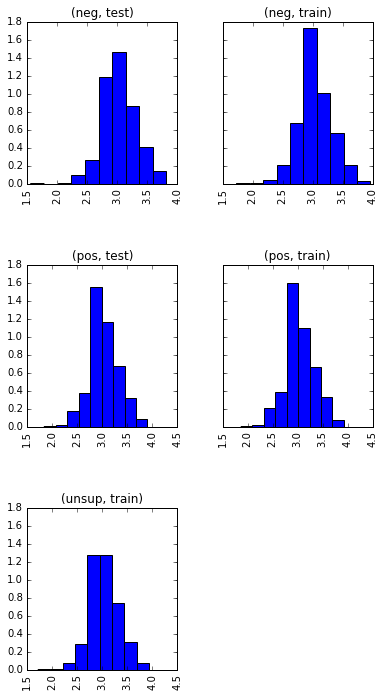

In [218]:
alldatadf[["judgement", "dataset", "review_log_len"]].\
    hist(by = ["judgement", "dataset"], figsize = (6,12),
         sharey=True, normed=True)
pass

## Iterating through a data frame

data frames have property

    df.iterrows() # for rows
    
and

    df.items()    # for columns

you probably will need the former more often. And don't forget about `.apply`

In [26]:
for key, value in alldatadf.iterrows():
    print(key)
    break

0


In [28]:
for key, value in alldatadf.items():
    print(key)

dataset
judgement
internal_id
stars
review
review_len
review_log_len


In [231]:
from sklearn import linear_model
X = alldatadf["review_log_len"].as_matrix().reshape(-1, 1)
y = alldatadf["stars"]
mo = linear_model.LinearRegression()
mo.fit(X, y)
print(mo.score(X, y))
print(mo.coef_)

0.000128951115312
[-0.1476958]


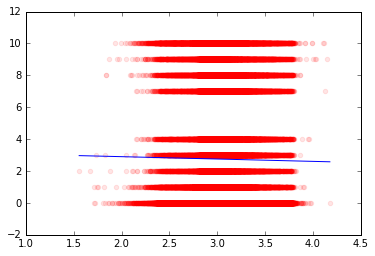

In [234]:
plt.scatter(X,y, color = (1,0,0,.1))
x_ = np.r_[min(X), max(X)]
plt.plot(x_, mo.intercept_ + mo.coef_*x_, "b-")
pass

In [237]:
pd.concat?

In [242]:
goodbad = pd.concat([alldatadf["review"].map(lambda x : "good" in x),
           alldatadf["review"].map(lambda x : "bad" in x)], 
          keys = ["good", "bad"],
         join="inner",
        axis=1)

goodbad.all(axis=1).sum() / goodbad.shape[0]

0.12714

In [ ]:
alldatadf[["judgement", "dataset", "review_len"]].groupby(["judgement", "dataset"]).hist

In [243]:
print(alldatadf["stars"].dtype)
alldatadf["stars"] = alldatadf["stars"].astype(int)
print(alldatadf["stars"].dtype)

int64
int64


In [8]:
alldatadf["stars"].value_counts().sort_index()

0     50000
1     10122
2      4586
3      4961
4      5331
7      4803
8      5859
9      4607
10     9731
Name: stars, dtype: int64

In [9]:
alldatadf["stars"][alldatadf["judgement"]!="unsup"].value_counts().sort_index()

1     10122
2      4586
3      4961
4      5331
7      4803
8      5859
9      4607
10     9731
Name: stars, dtype: int64

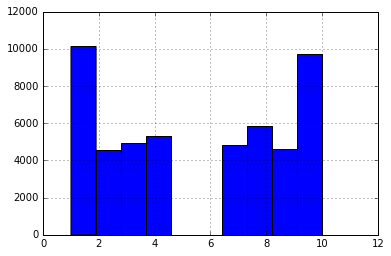

In [10]:
alldatadf["stars"][alldatadf["judgement"]!="unsup"].hist()

In [11]:
alldatadf.groupby(["judgement", "dataset"]).agg("count")

internal_id  stars  review
judgement dataset                            
neg       test           12500  12500   12500
          train          12500  12500   12500
pos       test           12500  12500   12500
          train          12500  12500   12500
unsup     train          50000  50000   50000

In [12]:
alldatadf.groupby(["judgement", "dataset"]).agg(np.mean)["stars"]

judgement  dataset
neg        test       2.22312
           train      2.21696
pos        test       8.80280
           train      8.73848
unsup      train      0.00000
Name: stars, dtype: float64

In [13]:
alldatadf.groupby(["dataset"]).agg(np.mean)["stars"]

dataset
test     5.512960
train    1.825907
Name: stars, dtype: float64

In [14]:
alldatadf[alldatadf["judgement"]!="unsup"].groupby(["dataset"]).agg(np.mean)["stars"]

dataset
test     5.51296
train    5.47772
Name: stars, dtype: float64

In [15]:
"remove unsupervised data points"
alldatadf = alldatadf[(alldatadf["judgement"]!="unsup")]

In [16]:
"replace textual judgement label by a binary/boolean label"
alldatadf["positive_judgement"] = alldatadf["judgement"] == "pos"
alldatadf.drop("judgement", axis=1, inplace=True)

In [17]:
train_data = alldatadf[(alldatadf["dataset"] == "train")].copy()
train_data.drop("dataset", axis=1, inplace=True)
# del alldatadf

## Run simple analysis with sklearn 

In [179]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# from nltk.tokenize import TreebankWordTokenizer
from sklearn.utils import shuffle

ngram_size = 3
vectorizer = TfidfVectorizer(ngram_range=(1, ngram_size), min_df = .1, stop_words='english')
# tokenizer=TreebankWordTokenizer().tokenize)

classifier_pipeline = Pipeline([
    ('count_vectorizer',   vectorizer),
    ('classifier',         MultinomialNB()),
])

In [180]:
ngrams = vectorizer.fit_transform(train_data[:20].review.as_matrix())
np.asarray(ngrams)

array(<20x361 sparse matrix of type '<class 'numpy.float64'>'
	with 1090 stored elements in Compressed Sparse Row format>, dtype=object)

In [164]:
num_points = 1000
# y = train_data[:num_points]["stars"].as_matrix()
y = shuffle(train_data["positive_judgement"])[:num_points]#.as_matrix()
X = train_data.loc[y.index.tolist()]["review"].as_matrix()
# ngrams = vect.fit_transform(X)
# KFold

## Estimate performance of the classifier model

In [165]:
from sklearn import cross_validation
cross_validation.cross_val_score(classifier_pipeline, X, y, cv = 5, scoring="roc_auc")

array([ 0.91756272,  0.90473319,  0.92302281,  0.90372827,  0.90115807])

## Fit model on the whole data set and inspect the weights

In [166]:
classifier_pipeline.fit(X,y)

Pipeline(steps=[('count_vectorizer', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=3,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_...      vocabulary=None)), ('classifier', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))])

In [167]:
cntv = classifier_pipeline.get_params()["count_vectorizer"]
cl = classifier_pipeline.get_params()["classifier"]
model_analysis = pd.DataFrame({"coef": cl.coef_[0]}, index=cntv.get_feature_names()) 

## confusion matrix

In [168]:
from sklearn import metrics
labels = [True, False]
yhat = classifier_pipeline.predict(X)
confmatr = pd.DataFrame(
    metrics.confusion_matrix(yhat, y, labels=labels),
    index = labels,
    columns = labels
    )
confmatr.index.name = "predicted"
confmatr.columns.name = "observed"
confmatr

observed,True,False
predicted,,
True,533,15
False,3,449


In [185]:
confmatr = pd.DataFrame({"yhat":yhat, 
                         "y": y,
                         "count":1}).groupby(["y", "yhat"]).agg(sum)
confmatr

count
y     yhat        
False False    449
      True      15
True  False      3
      True     533

In [187]:
pd.pivot_table(confmatr.reset_index(), columns="y", index="yhat")

count      
y     False True 
yhat             
False   449     3
True     15   533

In [170]:
cl.intercept_

array([-0.62362112])

In [171]:
model_analysis["voc"] =  [cntv.vocabulary_[kk] for kk in model_analysis.index.tolist()]

In [178]:
ntop = 10
pd.DataFrame({
            "negative": model_analysis["coef"].sort_values()[:ntop].index,
            "positive":model_analysis["coef"].sort_values()[-ntop:].index
             })

,negative,positive
0,film bad,best
1,look like citizen,just
2,cliches,really
3,clichéd,time
4,unoriginal,story
5,lock,good
6,seen long,like
7,seen long time,great
8,load,movie
9,lo,film


In [78]:
from sklearn.linear_model import ElasticNetCV

In [79]:
regression_pipeline = Pipeline([
    ('count_vectorizer',   vectorizer),
    ('regression',         ElasticNetCV(l1_ratio=0.5)),
])

In [61]:
ngrams = vectorizer.fit_transform(train_data[:2000].review.as_matrix())
np.asarray(ngrams)
valid = np.asarray(ngrams.sum(0)).ravel()>3
print(valid.shape)
print(valid.sum())

31265

In [ ]:
ngrams.shape

In [73]:
ngrams_selected = ngrams[:,np.where(valid)[-1]]
# valid.shape

In [65]:
valid

array([ True, False, False, ..., False, False, False], dtype=bool)

In [188]:
from sklearn import cross_validation
cross_validation.cross_val_score(regression_pipeline, X, y, cv=5, scoring="r2")

KeyboardInterrupt: 

In [ ]:

# split a training set and a test set
y_train, y_test = data_train.target, data_test.target


print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', non_negative=True,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.data)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.data)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."


###############################################################################
# Benchmark classifiers
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, category in enumerate(categories):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s"
                      % (category, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=categories))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="lsqr"), "Ridge Classifier"),
        (Perceptron(n_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(n_iter=50), "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(n_estimators=100), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(loss='l2', penalty=penalty,
                                            dual=False, tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, n_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', LinearSVC(penalty="l1", dual=False, tol=1e-3)),
  ('classification', LinearSVC())
])))

# make some plots

indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='r')
plt.barh(indices + .3, training_time, .2, label="training time", color='g')
plt.barh(indices + .6, test_time, .2, label="test time", color='b')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()